In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [34]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 5

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [36]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [37]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 0 2 0 1 0 1 1 2 0 1 0 0 1 1 2 0 2 1 0 1 0 1 0 2 0 0 1 0 0 0]


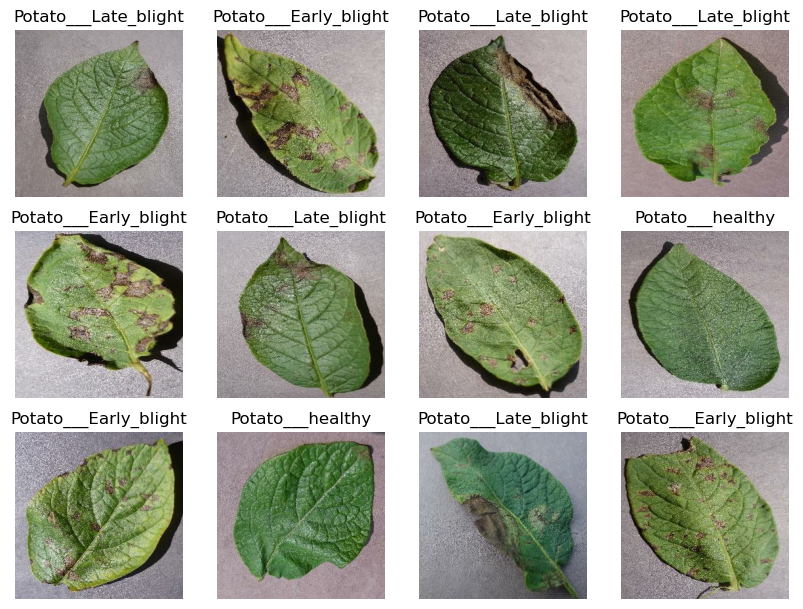

In [38]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,4,1+i)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

80% ==> Training
10% ==> Validation
10% ==> Test

In [39]:
len(dataset)

68

In [40]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [41]:
train_ds = dataset.take(54)
len(train_ds)

54

In [42]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [43]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [44]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [45]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [46]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_split + val_split) ==1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [47]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [48]:
len(train_ds)

54

In [49]:
len(test_ds)

8

In [50]:
len(val_ds)

6

In [51]:
54*32

1728

In [52]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [53]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[1].numpy())

[[[194. 197. 206.]
  [187. 190. 199.]
  [185. 188. 197.]
  ...
  [146. 143. 154.]
  [146. 143. 154.]
  [144. 141. 152.]]

 [[209. 212. 221.]
  [193. 196. 205.]
  [169. 172. 181.]
  ...
  [155. 152. 163.]
  [152. 149. 160.]
  [147. 144. 155.]]

 [[202. 205. 214.]
  [179. 182. 191.]
  [176. 179. 188.]
  ...
  [155. 152. 163.]
  [150. 147. 158.]
  [145. 142. 153.]]

 ...

 [[154. 152. 165.]
  [149. 147. 160.]
  [152. 150. 163.]
  ...
  [128. 126. 139.]
  [122. 120. 133.]
  [116. 114. 127.]]

 [[155. 153. 166.]
  [152. 150. 163.]
  [153. 151. 164.]
  ...
  [117. 115. 128.]
  [112. 110. 123.]
  [107. 105. 118.]]

 [[153. 151. 164.]
  [153. 151. 164.]
  [150. 148. 161.]
  ...
  [114. 112. 125.]
  [111. 109. 122.]
  [109. 107. 120.]]]


In [54]:
## Data Augmentation

In [55]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [56]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [57]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [58]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [59]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [60]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= EPOCHS
)

Epoch 1/5
54/54 [==============================] - 118s 2s/step - loss: 0.9062 - accuracy: 0.5336 - val_loss: 0.7680 - val_accuracy: 0.6406
Epoch 2/5
54/54 [==============================] - 88s 2s/step - loss: 0.6668 - accuracy: 0.7124 - val_loss: 0.4235 - val_accuracy: 0.8073
Epoch 3/5
54/54 [==============================] - 105s 2s/step - loss: 0.3935 - accuracy: 0.8374 - val_loss: 0.3714 - val_accuracy: 0.8594
Epoch 4/5
54/54 [==============================] - 106s 2s/step - loss: 0.3501 - accuracy: 0.8594 - val_loss: 0.2565 - val_accuracy: 0.8698
Epoch 5/5
54/54 [==============================] - 91s 2s/step - loss: 0.2642 - accuracy: 0.8958 - val_loss: 0.2970 - val_accuracy: 0.8698


In [61]:
len(test_ds)

8

In [65]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 4s 348ms/step - loss: 0.3069 - accuracy: 0.8828


[0.3069462180137634, 0.8828125]

In [66]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [67]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [68]:
history.history['loss']

[0.9061614871025085,
 0.666793704032898,
 0.3935355544090271,
 0.35013243556022644,
 0.2642177641391754]

In [69]:
history.history['accuracy']

[0.5335648059844971,
 0.7123842835426331,
 0.8373842835426331,
 0.859375,
 0.8958333134651184]

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

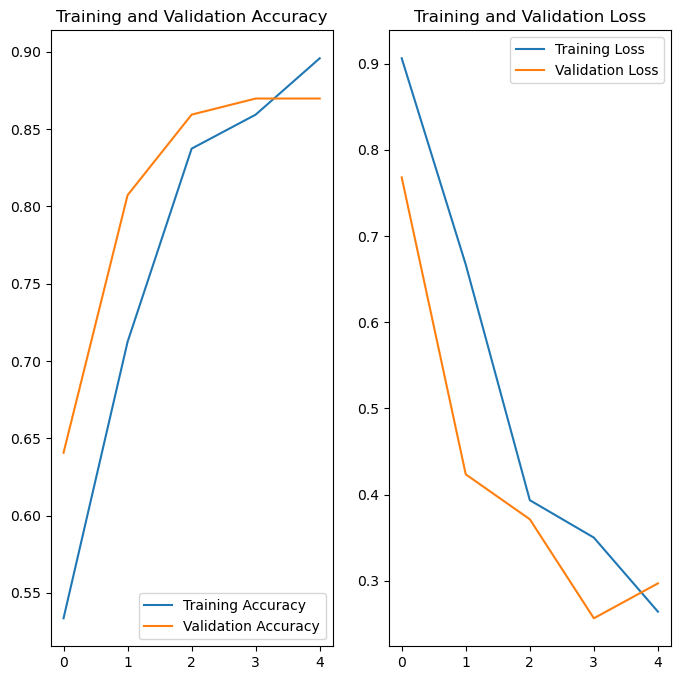

In [72]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 343ms/step
predicted label: Potato___Late_blight
confidence:  93.64


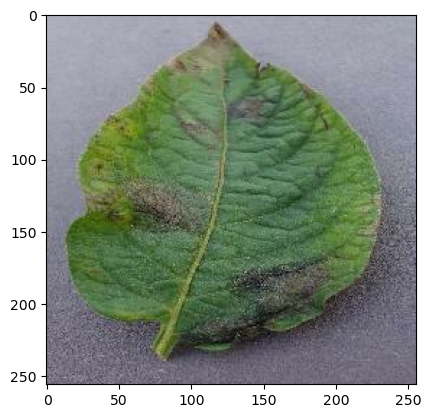

In [84]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    confidence = round(100*np.max(batch_prediction[0]), 2) 
    print("confidence: ",confidence)

In [90]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


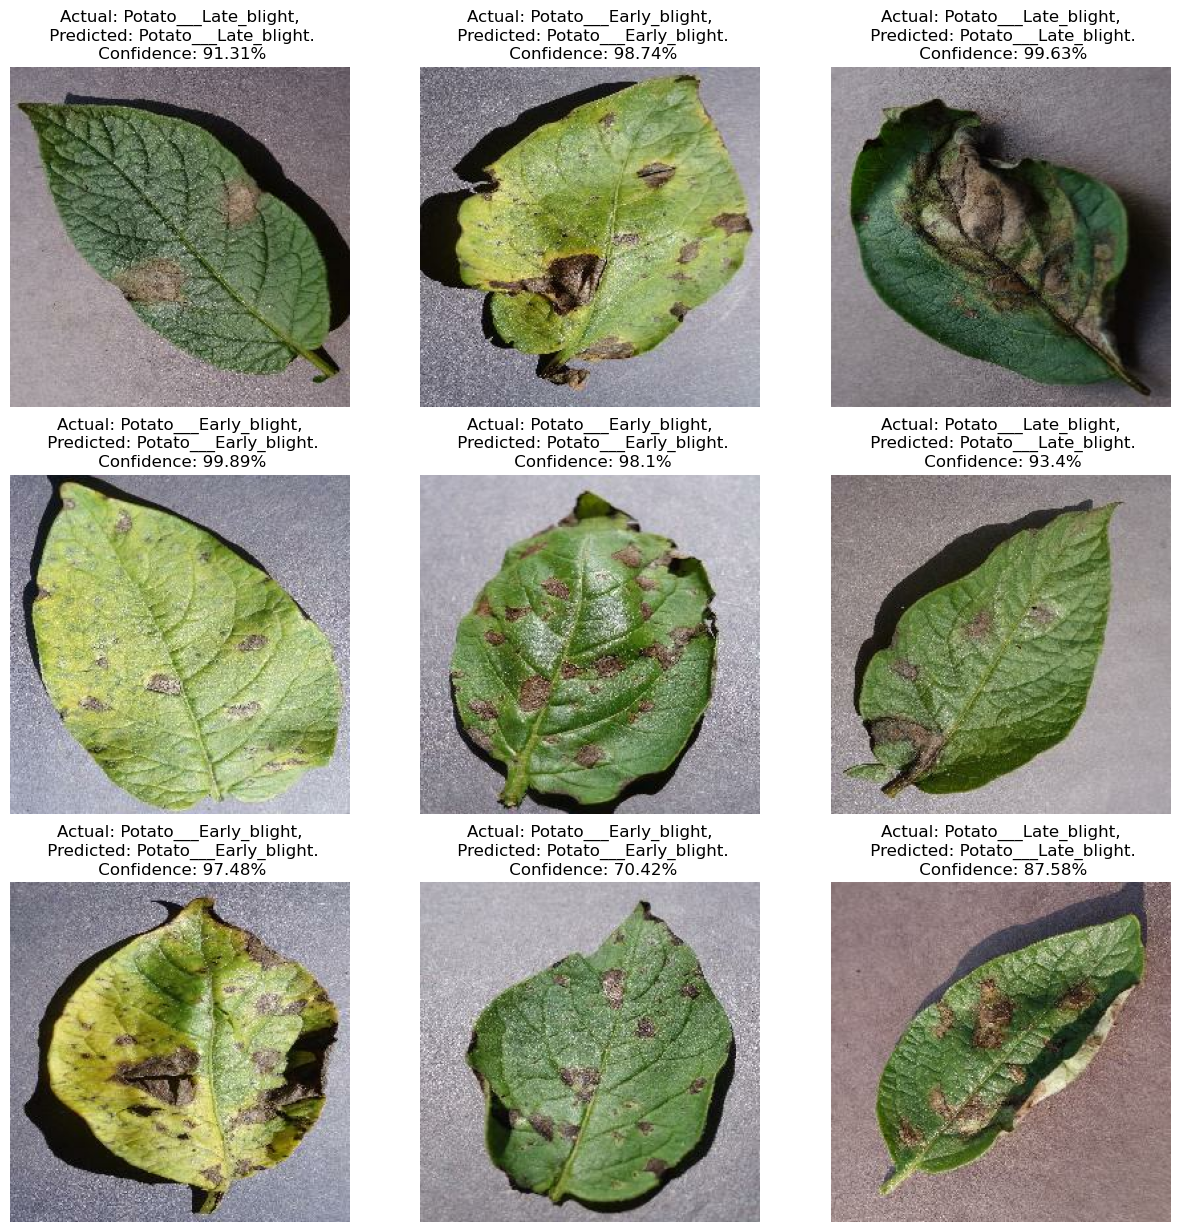

In [92]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the model

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../potatoes.h5")